In [1]:
import numpy as np
import pandas as pd
import psycopg2
import sys
from datetime import time

In [2]:
df = pd.read_csv('sampled_flights_total.csv', low_memory = False)

In [3]:
# Define function to identify columns with missing values
def missing_vals(x):
    total = x.isnull().sum().sort_values(ascending=False)
    percent = (x.isnull().sum()/x.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [5]:
df.dtypes

fl_date                 object
mkt_unique_carrier      object
branded_code_share      object
mkt_carrier             object
mkt_carrier_fl_num       int64
op_unique_carrier       object
tail_num                object
op_carrier_fl_num        int64
origin_airport_id        int64
origin                  object
origin_city_name        object
dest_airport_id          int64
dest                    object
dest_city_name          object
crs_dep_time             int64
dep_time               float64
dep_delay              float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time             int64
arr_time               float64
arr_delay              float64
cancelled              float64
cancellation_code       object
diverted               float64
dup                     object
crs_elapsed_time       float64
actual_elapsed_time    float64
air_time               float64
flights                float64
distance

In [7]:
# drop rows with only NaN
df.dropna(axis=1, how = 'all', inplace=True)

In [9]:
df_flights = df.copy()
flights=df_flights[[
       'mkt_unique_carrier',
        'origin_airport_id',
        'origin',
        'origin_city_name',        
        'dest_airport_id',          
        'dest',                    
        'dest_city_name',
        'crs_dep_time',             
        'dep_time',              
        'dep_delay',             
        'taxi_out',               
        'wheels_off',            
        'wheels_on',              
        'taxi_in',               
        'crs_arr_time',             
        'arr_time',               
        'arr_delay',            
        'cancelled',             
        'cancellation_code',                   
        'crs_elapsed_time',
        'actual_elapsed_time',
        'air_time',
        'flights',
        'distance',
        'carrier_delay',
        'weather_delay',
        'nas_delay',
        'security_delay',
        'late_aircraft_delay',
        ]]

In [10]:
#flights.to_csv("flights.csv", index = False, header=True)

In [11]:
# Create seperate table with all cancelled flights
cancelled_flights = flights[flights['cancelled'] == 1]

In [12]:
# drop columns not applicable to flights that were cancelled
cancelled_flights = cancelled_flights.drop(columns=[ 'air_time', 'actual_elapsed_time', 'wheels_off', 'taxi_out','wheels_on', 'taxi_in', 'crs_elapsed_time',
                                                    'crs_arr_time', 'arr_time', 'arr_delay', 'dep_delay', 'dep_time', 'carrier_delay',
                                                    'weather_delay', 'nas_delay','security_delay','late_aircraft_delay', 'distance', 'cancelled',  ])
missing_vals(cancelled_flights)

,Total,Percent
flights,0,0.0
cancellation_code,0,0.0
crs_dep_time,0,0.0
dest_city_name,0,0.0
dest,0,0.0
dest_airport_id,0,0.0
origin_city_name,0,0.0
origin,0,0.0
origin_airport_id,0,0.0
mkt_unique_carrier,0,0.0


In [16]:
# Create table without cancelled flights
complete_flights = flights[flights['cancelled'] != 1]
complete_flights = complete_flights.drop(columns=[  'cancelled', 'cancellation_code' ])

In [18]:
missing_vals(complete_flights)

,Total,Percent
late_aircraft_delay,1585977,0.807688
nas_delay,1585977,0.807688
weather_delay,1585977,0.807688
carrier_delay,1585977,0.807688
security_delay,1585977,0.807688
air_time,5663,0.002884
arr_delay,5253,0.002675
actual_elapsed_time,4917,0.002504
wheels_on,1466,0.000747
taxi_in,1466,0.000747


In [19]:
## Deal with missing values - replace NaN with 0 for delay code
complete_flights["weather_delay"] = complete_flights["weather_delay"].fillna(0)
complete_flights["nas_delay"] = complete_flights["nas_delay"].fillna(0)
complete_flights["security_delay"] = complete_flights["security_delay"].fillna(0)
complete_flights["late_aircraft_delay"] = complete_flights["late_aircraft_delay"].fillna(0)
complete_flights["carrier_delay"] = complete_flights["carrier_delay"].fillna(0)
complete_flights["dep_delay"] = complete_flights["dep_delay"].fillna(0)

#drop remaining rows with missing values - after examination these flights had either never departed, were duplicates or hadn't arrived at intended destination
complete_flights['taxi_out'].replace('', np.nan, inplace=True)
complete_flights['wheels_off'].replace('', np.nan, inplace=True)
complete_flights['wheels_on'].replace('', np.nan, inplace=True)
complete_flights['arr_time'].replace('', np.nan, inplace=True)
complete_flights['air_time'].replace('', np.nan, inplace=True)
complete_flights['arr_delay'].replace('', np.nan, inplace=True)
complete_flights['actual_elapsed_time'].replace('', np.nan, inplace=True)
complete_flights['taxi_in'].replace('', np.nan, inplace=True)


complete_flights.dropna(inplace=True)


In [21]:
# import seaborn
import seaborn as sns
from scipy.stats import ttest_1samp

# import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import os

# Normality Testing
from scipy.stats import anderson
from scipy.stats import shapiro

# import geopandas 
import geopandas as gpd
import geopy
import plotly.graph_objs as go
%matplotlib inline

Task 1: Test the hypothesis that the delay is from Normal distribution. and that mean of the delay is 0. Be careful about the outliers.

1. Check mean and distribution for departure delays to assess data prior to outlier detection.
- Visualize with distplot, histogram and QQ plot.
    - Q-Q plot compares quantiles of the actual data with the quantiles of shold be for standardized normal distribution
2. Check for outliers
- Use IsolationForest
    - Clean outliers
3. Check distribution/kurtosis/skew
    - Anderson- Darling test due to size of data
    - Shapiro-Wilk test

In [22]:
data = complete_flights['dep_delay']

In [23]:
data.describe()

count    1.957600e+06
mean     1.048717e+01
std      4.765769e+01
min     -1.730000e+02
25%     -6.000000e+00
50%     -2.000000e+00
75%      7.000000e+00
max      1.966000e+03
Name: dep_delay, dtype: float64

In [24]:
data.mean()

10.487172558234573

## Prior to any modification to data, mean is 10.487. **Not** 0

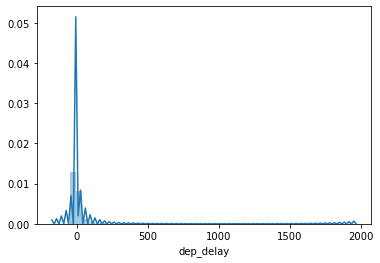

In [25]:
sns.distplot(data)

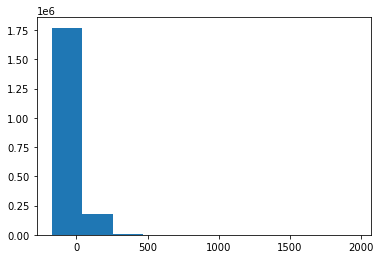

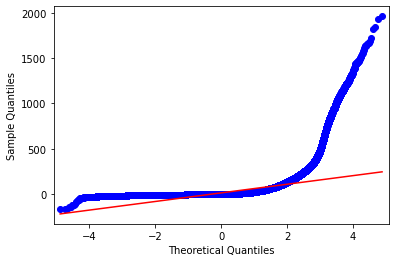

In [26]:
plt.hist(data)
qqplot(data, line = 's')
plt.show()

## Visualisations suggest that data distribution is far from normal.
- Distplot indicates possible bimodal distribution 
- QQ plot shows that actual data varies wildly from the normal distribution.

## Outliers

The visualizations imply heavily skewed data. I will utilize IsolationForest and adjust the dataset using filters to see if this can produce a more "normal" distribution. I will also asses the other delay columns to determine if any of them are Gaussian.

In [31]:
#Identify columns to for analysis
cols = ['dep_delay',
        'carrier_delay',
        'weather_delay',
        'nas_delay',
        'security_delay',
        'late_aircraft_delay',]

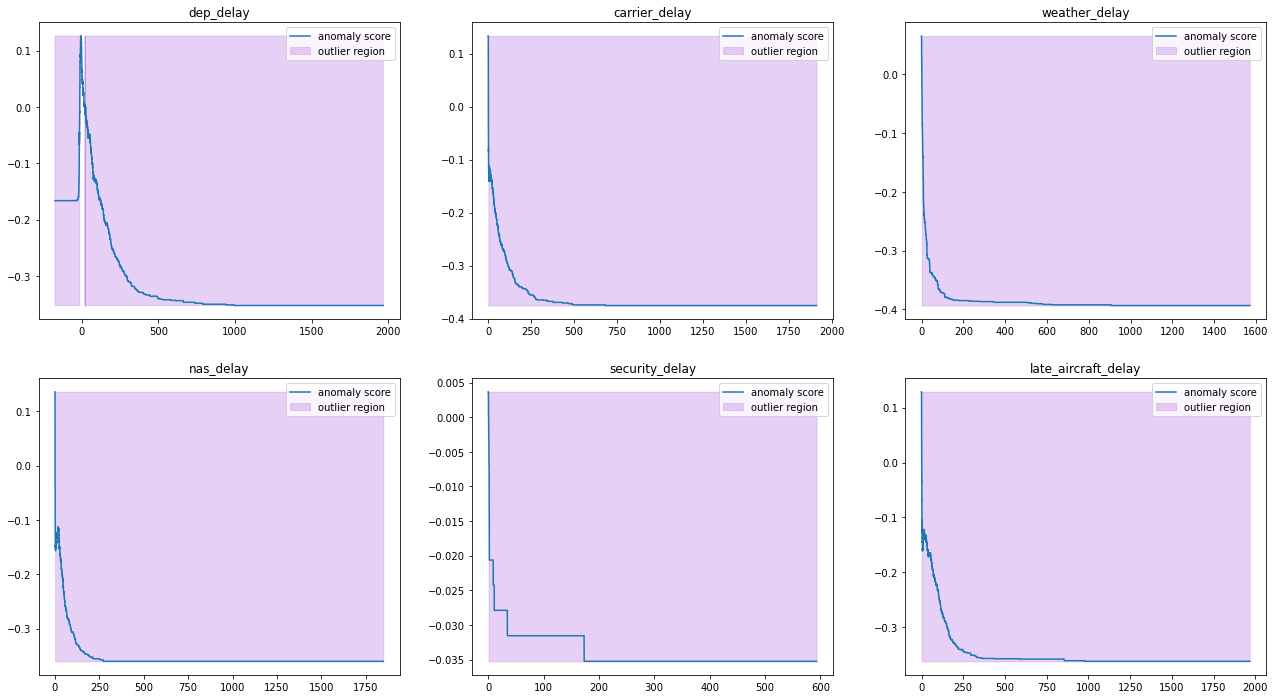

In [33]:
#import package
from sklearn.ensemble import IsolationForest

#Set plot configuration
fig, axs = plt.subplots(2, 3, figsize = (22, 12), facecolor = 'w', edgecolor = 'k')
axs = axs.ravel()

#Iterate through specified columns and isolate outliers(points outside a specified anomoly score)
for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(complete_flights[column].values.reshape(-1,1))

    xx = np.linspace(complete_flights[column].min(), complete_flights[column].max(), len(complete_flights)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                       where = outlier ==-1, color='#C58BE7',
                       alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

## Interpreting and cleaning outliers
It appears that almost everything is an outlier and that all delays follow a similar distribution. **dep_delay** differes slightly from the others based on the fact that it is the only column which allows for negatvie delays. (Flights that have departed early, which I maintain should not be considered when assessing flight delays.. but that's a story for another day).

Being that the bulk of the data falls within the outlier region I will adjust the dataset to reflect points within two standard deviations of the current mean to eliminate the extreme outliers.

In [144]:
def outlier_alert(df, col, x):
    std = df[col].std()
    mean = df[col].std()
    std_top = mean + std*x
    std_bottom = mean - std*x
    clean_dep = df[df[col] >= std_bottom]
    cleaner_dep = clean_dep[clean_dep[col] <= std_top]
    return cleaner_dep

clean = outlier_alert(complete_flights,'dep_delay', 2)
data_clean = clean['dep_delay']
data_clean.describe()

count    1.926883e+06
mean     5.792062e+00
std      2.376518e+01
min     -4.500000e+01
25%     -6.000000e+00
50%     -2.000000e+00
75%      5.000000e+00
max      1.430000e+02
Name: dep_delay, dtype: float64

## Mean still != 0. 

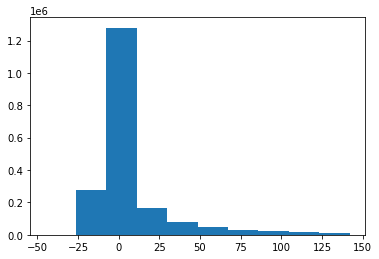

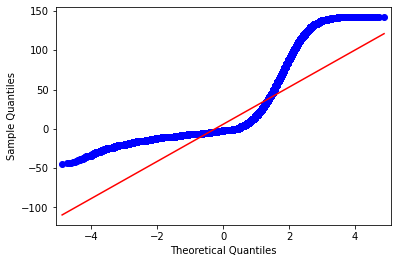

In [37]:
plt.hist(data_clean)
qqplot(data_clean, line = 's')
plt.show()

Skewness: 2.934987
Kurtosis: 9.496272


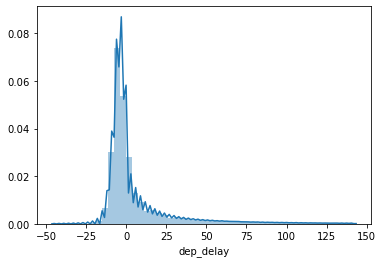

In [38]:
sns.distplot(data_clean)

#skewness and kurtosis
print('Skewness: %f' % data_clean.skew())
print('Kurtosis: %f' % data_clean.kurt())

## Visuals still reflect non-normal distribution.

Kurtosis and Skewness far exceed normal range of -1 to +1 indicating that indeed the peak is to extreme for normal distribution and that the data is Positively Skewed.

In [39]:
# Anderson-Darling test
result = anderson(data_clean)
print('Statistic: %.3f' % result.statistic)
p = 0 
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' %(sl, cv))
    else: 
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 246867.541
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [40]:
# Shapiro-Wilk Test
stat, p = shapiro(data_clean)
print('Statistics = %.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p> alpha:
    print('Sample looks Gaussian(fail to reject H0)')
else:
    print('Second opinion confirms, delays highly abGaussian(reject H0)')

Statistics = 0.628, p=0.000
Second opinion confirms, delays highly abGaussian(reject H0)


/Users/jessicashea/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Conclusion

Delays do not follow normal distribution. H0 rejected!

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

## Hypothesis and Methods
- Weather does affect delay but not all weather affect different airports equally.
     - 3 inches of snow in Chicago would have a minor impact where as 3 inches of snow in Washington DC brings the airports to a screeching halt
     - Rain in the New York region is often accompanied with lightning because of temperature and topography and is exceptionally restrictive. San Francisco doesn't experience as much convective activity thus rain is not the major concern.
         - Compare EWR vs SFO
- Weather affects high volume airports more than low volume airports. 
    - Inclement weather adds an exponential strain on resources if already over capacity
        - Compare ORD vs MDW


In [41]:
# import the widgets
import ipywidgets as widgets

# import plotly 
import plotly.graph_objects as go

# Datetime
from datetime import datetime 
import datetime as dt

In [42]:
complete_flights = pd.read_csv('sampled_flights_total.csv', low_memory = False)

In [43]:
complete_flights.dtypes

fl_date                 object
mkt_unique_carrier      object
branded_code_share      object
mkt_carrier             object
mkt_carrier_fl_num       int64
op_unique_carrier       object
tail_num                object
op_carrier_fl_num        int64
origin_airport_id        int64
origin                  object
origin_city_name        object
dest_airport_id          int64
dest                    object
dest_city_name          object
crs_dep_time             int64
dep_time               float64
dep_delay              float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time             int64
arr_time               float64
arr_delay              float64
cancelled              float64
cancellation_code       object
diverted               float64
dup                     object
crs_elapsed_time       float64
actual_elapsed_time    float64
air_time               float64
flights                float64
distance

In [44]:
complete_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-11-11,WN,WN,WN,410,WN,N7842A,410,13495,MSY,...,1062.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-11-11,WN,WN,WN,2149,WN,N420WN,2149,13495,MSY,...,604.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-11-11,WN,WN,WN,1884,WN,N7867A,1884,13796,OAK,...,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-11-11,WN,WN,WN,683,WN,N8510E,683,13796,OAK,...,2447.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-11-11,WN,WN,WN,123,WN,N8635F,123,13796,OAK,...,1933.0,0.0,0.0,15.0,0.0,0.0,NaN,NaN,NaN,NaN


In [75]:
#For the purpose of looking at delayed flights, I filtered out flights that left early due to the fact that one flight leaving early neutralizes delays
delayed_flight = complete_flights[complete_flights['dep_delay'] >0]
delayed_flights = delayed_flight.drop(['origin_city_name','dest_city_name','distance', 'air_time','security_delay', 'flights','dep_time', 'crs_elapsed_time','wheels_on', 'wheels_off','taxi_in','arr_time', 'taxi_out'], axis=1)

In [76]:
delayed_flights.to_csv("delayedflights.csv", index = False, header=True)

In [77]:
df_delay = delayed_flights

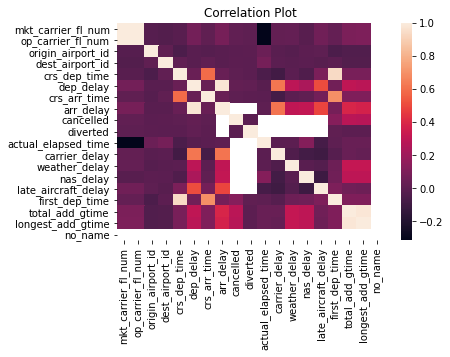

In [78]:
df_corr = df_delay.corr()
sns.heatmap(df_corr)
plt.title('Correlation Plot')
plt.show()

In [79]:
delayed_flights['dep_delay'].describe()

count    670310.000000
mean         40.615820
std          72.846956
min           1.000000
25%           6.000000
50%          17.000000
75%          46.000000
max        1966.000000
Name: dep_delay, dtype: float64

In [80]:
delayed_flights['dep_delay'].describe()

count    670310.000000
mean         40.615820
std          72.846956
min           1.000000
25%           6.000000
50%          17.000000
75%          46.000000
max        1966.000000
Name: dep_delay, dtype: float64

In [81]:
#further filtered to include only delays coded to weather
wxx_dly = delayed_flights[delayed_flights['weather_delay'] > 0]

wxx_dly['weather_delay'].describe()

count    22970.000000
mean        59.620636
std        109.717739
min          1.000000
25%         11.000000
50%         26.000000
75%         63.000000
max       1570.000000
Name: weather_delay, dtype: float64

#### **The mean departure delay for flights that have not had a delay coded to weather is `40.5 minutes`.**   
  
#### **The mean departure delay for flights where at least part of the delay is coded to weather is `96 minutes`.**

This is more than double. The mean weather delay is `59.6 minutes`. Weather delays do appear to have more of an impact than non-weather delays, although they make up only `2.3%` of all delay minutes. They also only account for `66%` of the delay on specificaly weather delayed flights.
- Do weather delays increase the chance of incurring other delays?
    - Late aircraft arrival delay in particular could include delays caused by but not explicitly coded to weather.

In [82]:
sort_wxx_routes.dtypes

mkt_carrier_fl_num               int64
op_carrier_fl_num                int64
dest_airport_id                  int64
crs_dep_time                     int64
dep_delay                      float64
crs_arr_time                     int64
arr_delay                      float64
cancelled                      float64
diverted                       float64
actual_elapsed_time            float64
carrier_delay                  float64
weather_delay                  float64
nas_delay                      float64
late_aircraft_delay            float64
first_dep_time                 float64
total_add_gtime                float64
longest_add_gtime              float64
no_name                        float64
amount_of_delay_due_weather    float64
dtype: object

In [161]:
#Identify routes that incur the most delays
wxx_dep = wxx_dly.groupby([ 'origin_airport_id', 'origin']).sum() 
sort_wxx_dep = wxx_dep.sort_values(by = 'dep_delay', ascending=False)

#Add coloumn to determine % of delay coded to weather
sort_wxx_dep['%_delay_weather'] = round(sort_wxx_dep['weather_delay']/sort_wxx_dep['dep_delay'], 3)*100
sort_wxx_dep['%_delay_late_aircraft'] = round(sort_wxx_dep['late_aircraft_delay']/sort_wxx_dep['dep_delay'], 3)*100
sort_wxx_dep['%_delay_nas'] = round(sort_wxx_dep['nas_delay']/sort_wxx_dep['dep_delay'], 3)*100
sort_wxx_dep['%_delay_carrier'] = round(sort_wxx_dep['carrier_delay']/sort_wxx_dep['dep_delay'], 3)*100
sort_wxx_dep = sort_wxx_dep.drop(['carrier_delay','nas_delay','mkt_carrier_fl_num','op_carrier_fl_num','dest_airport_id', 'crs_dep_time','crs_arr_time', 'arr_delay','cancelled', 'diverted','actual_elapsed_time', 'first_dep_time','total_add_gtime','longest_add_gtime', 'no_name'], axis=1)

sort_wxx_dep

,,dep_delay,weather_delay,late_aircraft_delay,%_delay_weather,%_delay_late_aircraft,%_delay_nas,%_delay_carrier
origin_airport_id,origin,,,,,,,
13930,ORD,222838.0,109661.0,94690.0,49.2,42.5,18.6,2.9
10397,ATL,156312.0,89072.0,52355.0,57.0,33.5,8.0,2.9
11298,DFW,155495.0,82810.0,63982.0,53.3,41.1,10.9,1.1
11057,CLT,100834.0,53634.0,41127.0,53.2,40.8,12.0,0.5
11292,DEN,88799.0,57453.0,27523.0,64.7,31.0,18.6,0.1
...,...,...,...,...,...,...,...,...
12888,LAR,25.0,25.0,0.0,100.0,0.0,188.0,0.0
10918,CDC,24.0,8.0,13.0,33.3,54.2,0.0,0.0
15897,WYS,20.0,6.0,9.0,30.0,45.0,0.0,0.0


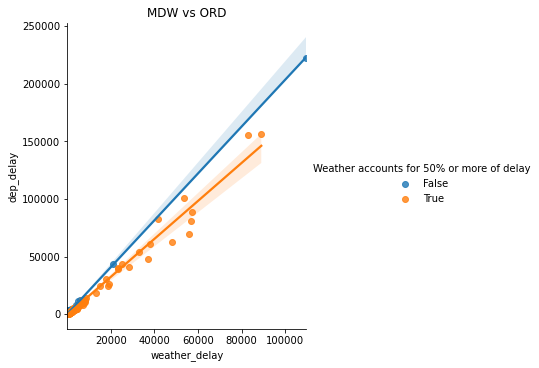

In [359]:
sort_wxx_dep['Weather accounts for 50% or more of delay'] = sort_wxx_dep['%_delay_weather'] >=50
delays= sns.lmplot(x='weather_delay', y='dep_delay', hue= 'Weather accounts for 50% or more of delay', data=sort_wxx_dep)
axes = delays.axes.flatten()
axes[0].set_title("MDW vs ORD")

plt.show()

#### Of the airports that experience the most departure delays, a significant amount of the delays are attributed to weather.

In [171]:
#Identify routes that incur the most  overall delays
dly_routes = delayed_flights.groupby([ 'origin_airport_id','dest_airport_id', 'origin', 'dest']).sum() 
sort_dly_routes = dly_routes.sort_values(by = 'dep_delay', ascending=False)
sort_dly_routes = sort_dly_routes.drop(['mkt_carrier_fl_num','op_carrier_fl_num', 'crs_dep_time','crs_arr_time', 'arr_delay','cancelled', 'diverted','actual_elapsed_time', 'first_dep_time','total_add_gtime','longest_add_gtime', 'no_name'], axis=1)
sort_dly_routes['amount_of_delay_due_weather'] = round(sort_dly_routes['weather_delay']/sort_dly_routes['dep_delay'], 3)*100
sort_dly_routes['amount_of_delay_late_aircraft'] = round(sort_dly_routes['late_aircraft_delay']/sort_dly_routes['dep_delay'], 3)*100

sort_dly_routes.head(10)

,,,,dep_delay,carrier_delay,weather_delay,nas_delay,late_aircraft_delay,amount_of_delay_due_weather,amount_of_delay_late_aircraft
origin_airport_id,dest_airport_id,origin,dest,,,,,,,
13930,12953,ORD,LGA,84244.0,12943.0,8425.0,36017.0,27339.0,10.0,32.5
12953,13930,LGA,ORD,77987.0,10471.0,5738.0,25169.0,35441.0,7.4,45.4
12892,14771,LAX,SFO,68521.0,9437.0,400.0,29813.0,23752.0,0.6,34.7
14771,12892,SFO,LAX,57607.0,11633.0,519.0,10942.0,30878.0,0.9,53.6
10721,12953,BOS,LGA,52137.0,10608.0,2381.0,17296.0,18138.0,4.6,34.8
13204,11618,MCO,EWR,51894.0,8905.0,1195.0,25678.0,13186.0,2.3,25.4
12953,10721,LGA,BOS,47030.0,8667.0,1655.0,11293.0,23349.0,3.5,49.6
12892,12478,LAX,JFK,46953.0,15035.0,39.0,15507.0,8541.0,0.1,18.2
10397,11618,ATL,EWR,43421.0,4386.0,2045.0,24486.0,8973.0,4.7,20.7


#### Chicago features heavily on both lists. 

To explore further and compare specific weather features on flight delays, I will isolate Chicago and combine with weather data. I've included MDW as well. Being that ORD handles more flights than almost every other airport, MDW will provide insight as to impact of volume with similar weather features.

In [172]:
# Chicago WXX
ORD_wxx_18_Q1 = pd.read_csv('ORD.csv')
MDW_wxx_18_Q1 = pd.read_csv('MDW.csv')
chi_weather=[ORD_wxx_18_Q1, MDW_wxx_18_Q1]

chi_wxx = pd.concat(chi_weather, axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

In [174]:
#Seperate Chicago departures for the same timeframe
chicago_dep_complete = delayed_flight[delayed_flight['origin_city_name'] == ('Chicago, IL')] 
chicago_dep_complete.sort_values(by='fl_date').set_index('fl_date')
chicago_dep_18_Q1 = chicago_dep_complete[chicago_dep_complete['fl_date'] < ('2018-04-01')] 

#Seperate Chicago arrivals for the same timeframe
chicago_arr_complete = delayed_flight[delayed_flight['dest_city_name'] == ('Chicago, IL')] 
chicago_arr_complete.sort_values(by='fl_date').set_index('fl_date')
chicago_arr_18_Q1 = delayed_flight[delayed_flight['fl_date'] < ('2018-04-01')] 

In [175]:
chi_flights = [chicago_dep_18_Q1, chicago_arr_18_Q1]
chi_flts = pd.concat(chi_flights, axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

In [176]:
chi_flts['fl_date'] = pd.to_datetime(chi_flts['fl_date'])

In [177]:
chi_flts.head(1)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
550341,2018-02-01,UA,UA_CODESHARE,UA,4263,EV,N14148,4263,13930,ORD,...,224.0,0.0,0.0,20.0,0.0,0.0,NaN,NaN,NaN,NaN


In [303]:
df = chi_flts.drop(columns=['no_name', 'first_dep_time', 'total_add_gtime', 'longest_add_gtime','carrier_delay', 'late_aircraft_delay','security_delay', 'nas_delay','weather_delay','op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id', 'wheels_off', 'wheels_on', 'cancellation_code', 'dup', 'crs_elapsed_time', 'flights'])
df['time'] = pd.cut(df['dep_time'], [0,300,600,900,1200,1500, 1800, 2100, 2400], labels=['0300', '0600', '0900', '1200', '1500', '1800', '2100', '2400'])
df = df.dropna(subset=['time'])
df['fl_date'] = df['fl_date'].dt.strftime('%Y-%m-%d')
df['time'] = df['time'].astype(str)
df['time'] = df['time'].replace(['2400'], '0000')
df['date_time'] = pd.to_datetime(df['fl_date'] + ' ' + df['time'])
df['date_time']

chi_wxx['date_time'] = pd.to_datetime(chi_wxx.date_time)
df = df.merge(chi_wxx, how='left')

In [304]:
missing_vals(df)

,Total,Percent
air_time,736,0.004601
arr_delay,680,0.004251
actual_elapsed_time,612,0.003826
taxi_in,376,0.002350
taxi_out,258,0.001613
arr_time,252,0.001575
location,0,0.000000
dep_time,0,0.000000
diverted,0,0.000000
cancelled,0,0.000000


In [326]:
chi_complete = df.drop(columns = ['WindChillC', 'tempC','visibility', 'crs_dep_time','mkt_unique_carrier','uvIndex','mintempC','maxtempC','cancelled', 'sunHour','moon_illumination','moonrise', 'HeatIndexC','WindGustKmph','winddirDegree', 'humidity','FeelsLikeC', 'distance','sunrise', 'sunset','diverted','moonset', 'taxi_out','taxi_in','actual_elapsed_time','branded_code_share', 'mkt_carrier', 'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num', 'origin_city_name'])

In [327]:
## Deal with missing values - replace NaN with 0 for delay code
chi_complete["dep_delay"] = chi_complete["dep_delay"].fillna(0)

# drop remainder of rows with NaN
chi_complete.dropna(axis=1, how = 'any', inplace=True)

In [343]:
#filter only flights that actually departed with a delay
chi_complete["late"] = chi_complete['dep_delay'] > 0


In [344]:
chi_complete_day=chi_complete.groupby(['fl_date']).mean()

Skewness: 6.955556
Kurtosis: 82.247657


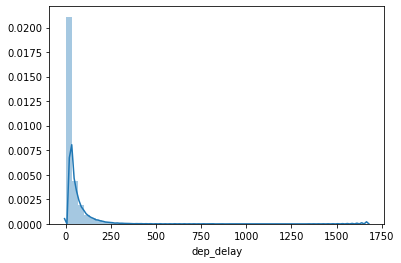

In [346]:
#Check for distribution/Kurtosis/Skewness
sns.distplot(chi_complete['dep_delay']);

print('Skewness: %f' % chi_complete['dep_delay'].skew())
print('Kurtosis: %f' % chi_complete['dep_delay'].kurt())

In [347]:
#Transform using boxcox to resolve heavy skew

from scipy import stats
chi_complete2['dep_delay'] = stats.boxcox(chi_complete2['dep_delay'])[0]

Skewness: 0.046209
Kurtosis: -0.501268


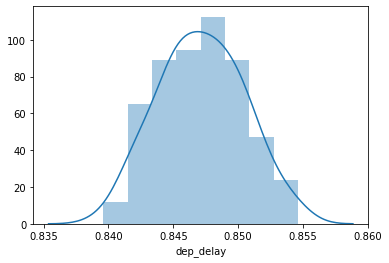

In [348]:
sns.distplot(chi_complete2['dep_delay']);

print('Skewness: %f' % chi_complete2['dep_delay'].skew())
print('Kurtosis: %f' % chi_complete2['dep_delay'].kurt())

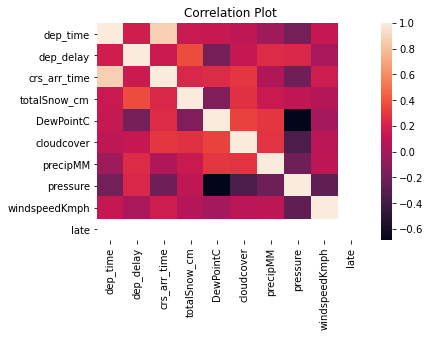

In [349]:
df_corr = chi_complete2.corr()
sns.heatmap(df_corr)
plt.title('Correlation Plot')
plt.show()

In [286]:
#save to csv for analysis in Tableau
chi_complete.to_csv("chicago.csv", index = True, header=True)

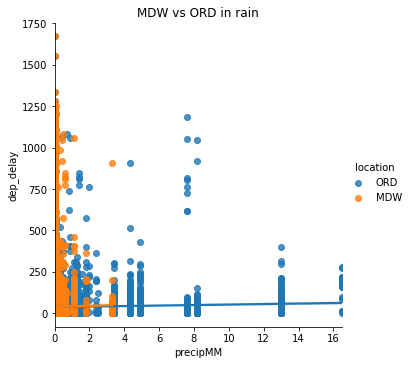

In [354]:
chi= sns.lmplot(x='precipMM', y='dep_delay', hue= 'location', data=chi_complete)
axes = chi.axes.flatten()
axes[0].set_title("MDW vs ORD in rain")

plt.show()

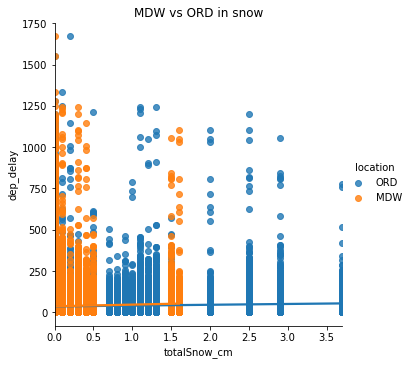

In [341]:
chi= sns.lmplot(x='totalSnow_cm', y='dep_delay', hue= 'location', data=chi_complete)
axes = chi.axes.flatten()
axes[0].set_title("MDW vs ORD in snow")

plt.show()

####  ORD appears to get much more snow and rain than MDW. 

Whether this is accurate or just a difference in reporting methods would require further analysis.

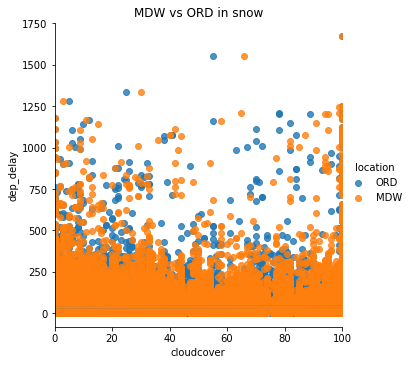

In [353]:
chi= sns.lmplot(x='cloudcover', y='dep_delay', hue= 'location', data=chi_complete)
axes = chi.axes.flatten()
axes[0].set_title("MDW vs ORD in snow")

plt.show()

DEPARTURE AIRPORTS WITH MOST WXX DELAYS
3. 10397 = ATL
1. 13930 = ORD
4. 13487 = MSP
2. 11298 = DFW
5. 12266 = IAH
6. 11292 = DEN
8. 12264 = IAD
7. 11618 = EWR

9. 11278 = DCA
10. 10423 = AUS

DEPARTURE AIRPORTS WITH MOST TOTAL DELAYS
1. 13930 = ORD
2. 10397 = ATL
3. 11298 = DFW
4. 11618 = EWR
5. 11292 = DEN
6. 14771 = SFO
7. 11057 = CLT
8. 12953 = LGA
9. 12892 = LAX
10. 10721 = BOS

DEPARTURE AIRPORTS WITH MOST NAS DELAY
1. 13930 = ORD
2. 11618 = EWR
3. 14771 = SFO
4. 12953 = LGA
5. 10721 = BOS
6. 11298 = DFW
7. 12478 = JFK
8. 11292 = DEN
9. 14100 = PHL
10. 10397 = ATL

ARRIVAL WXX
1.  13930 = ORD
2.  12953 = LGA
3.  11292 = DEN
4.  11298 = DFW
5.  10397 = ATL
6.  12266 = IAH
7.  11618 = EWR
8.  11433 = DTW
9.  11057 = CLT
10. 14869 = SLC

ARRIVAL AIRPORTS TOTAL DELAY
1.  13930 = ORD
2.  11298 = DFW
3.  10397 = ATL
4.  11292 = DEN
5.  11618 = DFW
6.  11057 = CLT
7.  12953 = LGA
8.  14771 = SFO
9.  12892 = LAX
10. 10721 = BOS

ARRIVAL AIRPORTS NAS DELAY
1.  13930 = ORD
2.  10397 = ATL
3.  11292 = DEN
4.  12953 = LGA
5.  11298 = DFW
6.  11433 = DTW
7.  11057 = CLT
8.  11618 = EWR
9.  12478 = JFK
10. 10721 = BOS

ROUTES - not suprising these are all relatively short flights. Another impact on delay appears to be distance between airports
1.  12953 LGA-ORD 13930
2.  11433 DTW-LGA 12953
3.  11433 DTW-EWR 11618
4.  12892 LAX-SFO 14771
5.  13930 ORD-LGA 12953
6.  12889 LAS-SFO 14771
7.  11298 DFW-ORD 13930
8.  14747 SEA-SFO 14771
9.  14679 SAN-SFO 14771
10. 12339 IND-EWR 11618

ROUTES ALL DLY
1.  12953 LGA-ORD 13930
2.  13930 ORD-LGA 12953
3.  14771 SFO-EWR 11618
4.  12892 LAX-SFO 14771
5.  13487 MSP-ORD 13930
6.  14771 SFO-LAX 12892
7.  11298 DFW-ORD 13930
8.  10721 BOS-ORD 12953
9.  11298 DFW-ORD 12953
10. 12889 LAS-SFO 14771

ROUTES NAS DLY
1.  12953 LGA-ORD 13930
2.  11433 DTW-LGA 12953
3.  11433 DTW-EWR 11618
4.  12892 LAX-SFO 14771
5.  13930 ORD-LGA 12953
6.  12889 LAS-SFO 14771
7.  11298 DFW-ORD 13930
8.  14747 SEA-SFO 14771
9.  14679 SAN-SFO 14771
10. 12339 IND-EWR 11618

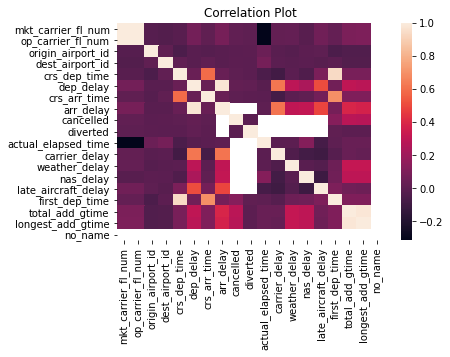

In [360]:
df_corr = delayed_flights.corr()
sns.heatmap(df_corr)
plt.title('Correlation Plot')
plt.show()

### Correlation Analysis


In [173]:
wxx_arr = wxx_dly.groupby(['fl_date','origin_airport_id','dest_airport_id']).mean()
sort_arr = wxx_arr.sort_values(by = 'dep_delay', ascending=False)
sort_arr.head(15)

,,,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
fl_date,origin_airport_id,dest_airport_id,,,,,,,,,,,,,,,,,,,,
2019-01-25,10792,11298,630.0,947.0,1637.0,34.0,1021.0,1204.0,7.0,922.0,1211.0,1609.0,232.0,204.0,163.0,1.0,1212.0,960.0,118.0,0.0,0.0,531.0
2019-11-29,14698,11292,628.0,859.0,1591.0,15.0,914.0,1212.0,6.0,1008.0,1218.0,1570.0,160.0,139.0,118.0,1.0,931.0,0.0,1570.0,0.0,0.0,0.0
2019-12-29,14489,11292,1212.0,1313.0,1501.0,23.0,1336.0,1636.0,12.0,1545.0,1648.0,1503.0,153.0,155.0,120.0,1.0,898.0,0.0,21.0,2.0,0.0,1480.0
2019-12-02,12889,14908,1320.0,1400.0,1480.0,11.0,1411.0,1454.0,13.0,1432.0,1507.0,1475.0,72.0,67.0,43.0,1.0,226.0,0.0,9.0,0.0,0.0,1466.0
2019-06-29,11042,11618,1100.0,1055.0,1435.0,14.0,1109.0,1210.0,24.0,1243.0,1234.0,1431.0,103.0,99.0,61.0,1.0,404.0,0.0,1431.0,0.0,0.0,0.0
2019-03-03,11503,11618,1225.0,1203.0,1418.0,17.0,1220.0,1731.0,8.0,1817.0,1739.0,1402.0,232.0,216.0,191.0,1.0,1725.0,0.0,1.0,0.0,0.0,1401.0
2018-12-14,14112,10431,2000.0,1816.0,1336.0,10.0,1826.0,1931.0,5.0,2130.0,1936.0,1326.0,90.0,80.0,65.0,1.0,519.0,0.0,1326.0,0.0,0.0,0.0
2019-04-03,12945,10397,1703.0,1505.0,1322.0,19.0,1524.0,1629.0,10.0,1835.0,1639.0,1324.0,92.0,94.0,65.0,1.0,304.0,0.0,1322.0,2.0,0.0,0.0
2019-09-27,13930,11697,1540.0,1323.0,1303.0,24.0,1347.0,1711.0,7.0,1952.0,1718.0,1286.0,192.0,175.0,144.0,1.0,1182.0,0.0,50.0,956.0,0.0,280.0


In [135]:
sns.lmplot(x='dep_delay', y='weather_delay', data=wxx_days, hue='fl_date')
axes = CvI.axes.flatten()
axes[0].set_title("Children vs Income")
plt.show()

KeyError: "['fl_date'] not in index"

/Users/jessicashea/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/jessicashea/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/jessicashea/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/jess

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fe3831eb0>,
      dtype=object)

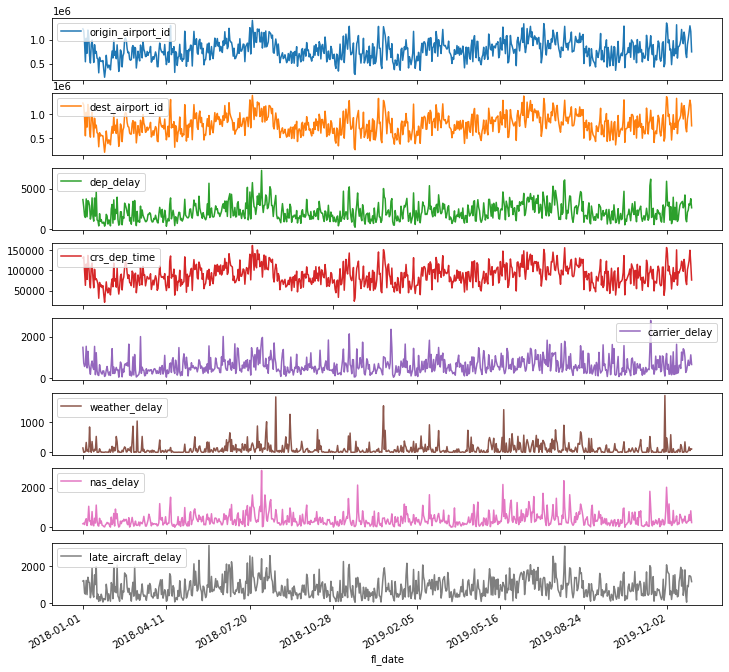

In [132]:
wxx_days.plot(subplots=True, figsize = (12,12))

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [362]:
delayed_flights['amount_due_late_aircraft'] = delayed_flights['late_aircraft_delay']/delayed_flights['dep_delay']
delayed_flights['Late'] =  delayed_flights['dep_delay'] > 0

In [363]:
dep_arr = delayed_flights[['dep_delay','amount_due_late_aircraft', 'Late','late_aircraft_delay']]

In [364]:
dep_arr = dep_arr[dep_arr['dep_delay']>0].sort_values(by='amount_due_late_aircraft', ascending=False)

In [365]:
dep_arr.head(20)

,dep_delay,amount_due_late_aircraft,Late,late_aircraft_delay
1857795,1.0,42.000000,True,42.0
1628257,2.0,23.500000,True,47.0
1492801,1.0,16.000000,True,16.0
383082,1.0,16.000000,True,16.0
1775000,11.0,10.545455,True,116.0
1614965,4.0,10.500000,True,42.0
349714,4.0,8.250000,True,33.0
1787115,8.0,8.125000,True,65.0
1806450,2.0,8.000000,True,16.0
890334,6.0,7.333333,True,44.0


In [366]:
mean_dep = round(dep_arr['dep_delay'].mean(),3)
mean_dep

40.616

In [367]:
mean_ac = round(dep_arr['late_aircraft_delay'].mean(),3)
mean_ac

31.046

In [368]:
mean_liac = round(dep_arr['amount_due_late_aircraft'].mean(),3)*100
print('Average percent of delay accounted for by late aircraft arrival:', mean_liac, '%')

Average percent of delay accounted for by late aircraft arrival: 41.099999999999994 %


The average percentage of departure delay accounted for by late arrival of aircraft is 20.4%. Airlines can make up time on delay. 

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

### Process
Identify routes with most delays.
- specifically long routes with enough distance to reflect an increase of speed
    - compare air time vs departure delay

In [369]:
dep_late = complete_flights[['fl_date', 'origin_airport_id','dest_airport_id','dep_delay', 'crs_dep_time',
                           'crs_arr_time', 'arr_delay','distance', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time']]

In [370]:
#group for routes to identify significant delays
leaving_late = dep_late.groupby(['origin_airport_id','dest_airport_id']).sum()
sort_late = leaving_late.sort_values(['air_time','dep_delay'], ascending=False)

#add column for aircraft speed
sort_late['Speed'] =  sort_late['air_time']/sort_late['distance']

In [371]:
sort_late.head(100)

,,dep_delay,crs_dep_time,crs_arr_time,arr_delay,distance,crs_elapsed_time,actual_elapsed_time,air_time,Speed
origin_airport_id,dest_airport_id,,,,,,,,,
12478,12892,21156.0,4337749,4620863,-11176.0,7962075.0,1225294.0,1183954.0,1061028.0,0.133260
12892,12478,37672.0,4278349,4517069,5647.0,7890300.0,1053700.0,1012480.0,920440.0,0.116655
12478,14771,23385.0,2537974,2781296,5254.0,4923744.0,762442.0,732795.0,661950.0,0.134440
14771,12478,26017.0,2716128,2668371,8108.0,4990980.0,653623.0,629567.0,568789.0,0.113963
11618,14771,25382.0,2009039,2311098,17455.0,3785940.0,563499.0,548513.0,496185.0,0.131060
...,...,...,...,...,...,...,...,...,...,...
11292,12953,16527.0,1324100,1933275,9293.0,1713960.0,236935.0,221983.0,194866.0,0.113693
14771,11298,15927.0,1222123,1766667,8298.0,1658712.0,243464.0,229656.0,194122.0,0.117032
10397,10721,25975.0,2203194,2294140,14631.0,1527790.0,249706.0,235570.0,194055.0,0.127017


I will look at JFK-LAX specifically due to it being a long route that should provide a somewhat even sample for flights that depart late and on time.

In [372]:
#Filter flights for JFK-LAX
JFK = complete_flights[complete_flights['origin_airport_id'] ==12478]
JFK_LAX = JFK[JFK['dest_airport_id'] ==  12892]
JFK_LAX = JFK_LAX[['fl_date', 'origin_airport_id','dest_airport_id','dep_delay', 'crs_dep_time', 'distance',
                           'crs_arr_time', 'arr_delay', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time']]
JFK_LAX.head()

,fl_date,origin_airport_id,dest_airport_id,dep_delay,crs_dep_time,distance,crs_arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time
567,2019-11-11,12478,12892,-14.0,705,2475.0,1024,-18.0,379.0,375.0,340.0
644,2019-11-11,12478,12892,-5.0,2240,2475.0,154,-11.0,374.0,368.0,344.0
1804,2019-11-12,12478,12892,-10.0,2015,2475.0,2355,-52.0,400.0,358.0,324.0
2889,2019-11-12,12478,12892,-8.0,800,2475.0,1116,-25.0,376.0,359.0,333.0
4091,2019-11-13,12478,12892,1.0,2129,2475.0,50,-8.0,381.0,372.0,352.0


In [373]:
#Add columns for speed and boolean to identify flights that departed late
JFK_LAX['Speed'] =  JFK_LAX['air_time']/JFK_LAX['distance']
JFK_LAX['Late'] =  JFK_LAX['dep_delay'] > 0

In [374]:
#Create table and similar filters to assess SFO-EWR as well
SFO = complete_flights[complete_flights['origin_airport_id'] ==11618]
SFO_EWR = SFO[SFO['dest_airport_id'] ==  14771]
SFO_EWR = SFO_EWR[['fl_date', 'origin_airport_id','dest_airport_id','dep_delay', 'crs_dep_time', 'distance',
                           'crs_arr_time', 'arr_delay', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time']]

SFO_EWR['Speed'] =  SFO_EWR['air_time']/SFO_EWR['distance']
SFO_EWR['Late'] =  SFO_EWR['dep_delay'] > 0

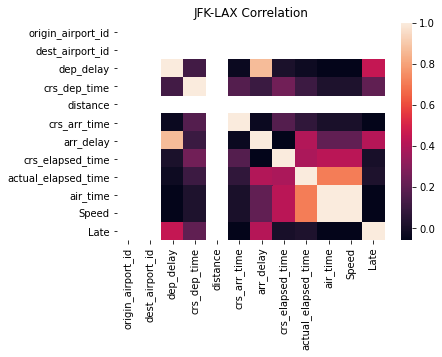

In [375]:
air_corr = JFK_LAX.corr()
sns.heatmap(air_corr)
plt.title('JFK-LAX Correlation')
plt.show()

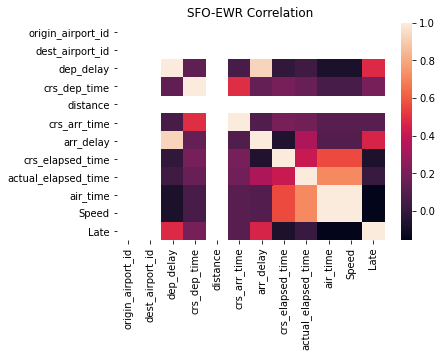

In [376]:
air_corr_west = SFO_EWR.corr()
sns.heatmap(air_corr_west)
plt.title('SFO-EWR Correlation')
plt.show()

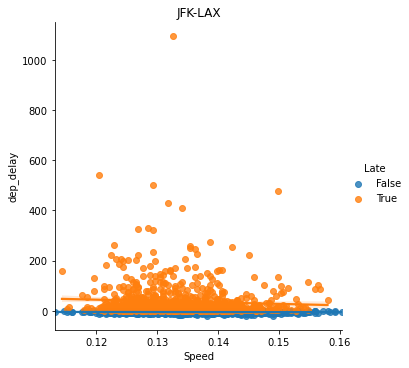

In [377]:
air_dly_east= sns.lmplot(y='dep_delay', x='Speed', hue= 'Late', data=JFK_LAX)
axes = air_dly_east.axes.flatten()
axes[0].set_title("JFK-LAX")

plt.show()

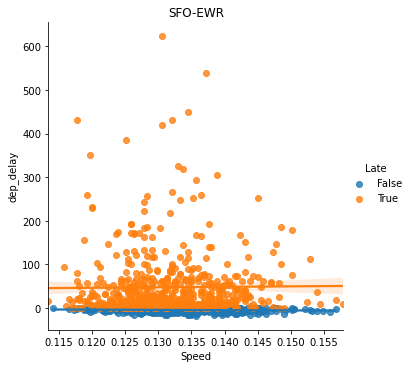

In [378]:
air_dly_west= sns.lmplot(y='dep_delay', x='Speed', hue= 'Late', data=SFO_EWR)
axes = air_dly_west.axes.flatten()
axes[0].set_title("SFO-EWR")

plt.show()

### Conclusion
Air time/speed seems to have no correlation with departure delay. 
- on the correlation plot, it appears that scheduled departure time has more to do with speed than anything else.
- arrival delay has stronger relation to speed than departure delay
    - Would be interesting to explore what time of day planes fly faster. This could be due to strength of headwind at varying times of the day or perhaps volumes of air traffic.
- I think it is still possible that planes fly faster when they depart late. If delays are caused by volume or weather at arrival airport, then there is increased chance of holding patterns or longer approaches on arrival. Further assessment would be necessary to determine this, either utilizing air traffic data or by assessing time between waypoints.

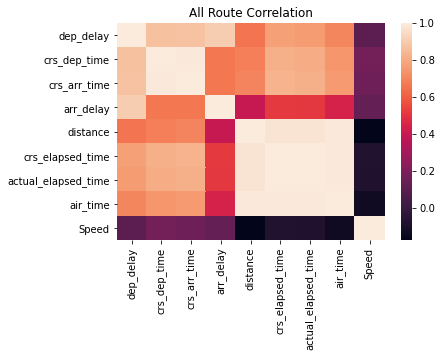

In [379]:
#Assess similarities to correlations all routes considered
air_corr_all = sort_late.corr()
sns.heatmap(air_corr_all)
plt.title('All Route Correlation')
plt.show()

In [380]:
#Compare with correlation to all late departures
sort_late['Late'] =  sort_late['dep_delay'] > 0
complete_flights['Speed'] =  complete_flights['air_time']/complete_flights['distance']
complete_flights['Late'] =  complete_flights['dep_delay'] > 0
speed_complete = complete_flights[['fl_date','Speed', 'origin_airport_id','dest_airport_id','dep_delay', 'crs_dep_time', 'distance',
                           'crs_arr_time', 'Late', 'arr_delay', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time']]


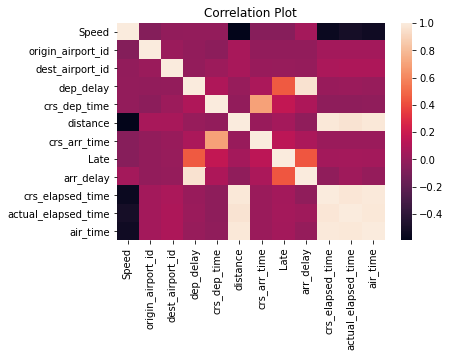

In [381]:
speed_corr = speed_complete.corr()
sns.heatmap(speed_corr)
plt.title('Correlation Plot')
plt.show()

In [382]:
#Assess DEN-LGA to see if fuel consumption could explain why speed varies between routes
DEN = complete_flights[complete_flights['origin_airport_id'] ==13930]
DEN_LGA= DEN[DEN['dest_airport_id'] ==  11292]
DEN_LGA = DEN_LGA[['fl_date', 'origin_airport_id','dest_airport_id','dep_delay', 'crs_dep_time', 'distance',
                           'crs_arr_time', 'arr_delay', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time']]
DEN_LGA.head()

,fl_date,origin_airport_id,dest_airport_id,dep_delay,crs_dep_time,distance,crs_arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time
1042,2019-11-12,13930,11292,26.0,1000,888.0,1145,22.0,165.0,161.0,121.0
1561,2019-11-12,13930,11292,30.0,1125,888.0,1305,11.0,160.0,141.0,116.0
3928,2019-11-13,13930,11292,-3.0,1000,888.0,1145,-11.0,165.0,157.0,137.0
5479,2019-11-13,13930,11292,-3.0,520,888.0,717,-14.0,177.0,166.0,138.0
6132,2019-11-13,13930,11292,1.0,1125,888.0,1305,-6.0,160.0,153.0,129.0


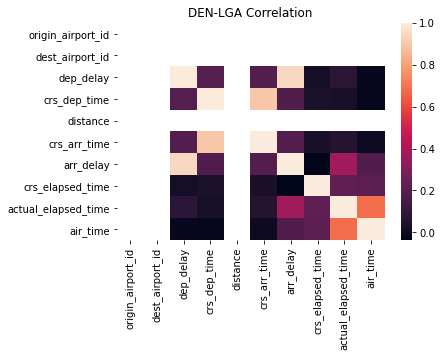

In [383]:
air_corr_DEN = DEN_LGA.corr()
sns.heatmap(air_corr_DEN)
plt.title('DEN-LGA Correlation')
plt.show()

NameError: name 'air_dly' is not defined

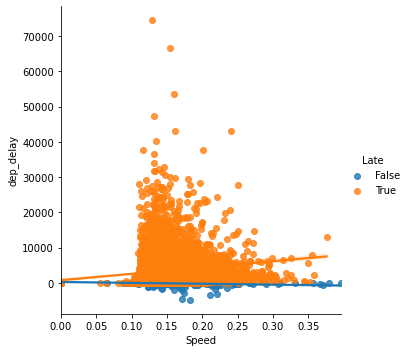

In [384]:
air_dly_all= sns.lmplot(y='dep_delay', x='Speed', hue= 'Late', data=sort_late)
axes = air_dly.axes.flatten()
axes[0].set_title("Air Time vs Delay")

plt.show()

## Conclusion Part Deux
When considering all routes, there is a correlation between departure delay and air speed. I thought maybe the routes I had chosen provided less opportunity to increase speed due to fuel required to complete the flight so I chose another route DEN-LGA and found similar results to the first two. Going back to my first conclusion I looked at the correlation between destination airport and speed. 
  
While the average speed does seem to increase with flight delays, there is another aspect involved as well.
- correlation plot indicates that destination airport is slightly higher in correlation to speed than delay is.
    - further analysis could be done to determine if this is due to size/speed of most common aircraft to service specific airports


#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

### Process
With `flights` database group by airport and count flights.
With `passengers` database group by airport and count passengers
- I believe that ATL is the busiest aiport due to cargo and that ORD is the busiest airport for PAX.
- Using `passengers` table, assess most saturated routes and least saturated.
    - where seats > 0, passengers/seats would indicate a percentage of seats on average that are filled. 
    - Routes with higher percentage suggest that there would be room in this market for additional carriers/flights


## Identify airports with most flights arriving and departing

In [ ]:
# Busiest inbound
airports = pd.DataFrame(complete_flights, columns=['origin', 'origin_airport_id','flights'])
traffic_out = airports.groupby(airports['origin']).count()
sorted_traffic_out = traffic_out.sort_values(by = 'flights', ascending = False)
sorted_traffic_out.head(10)

In [ ]:
# Busiest outbound
airports = pd.DataFrame(complete_flights, columns=['dest', 'dest_airport_id','flights'])
traffic_in = airports.groupby(airports['dest']).count()
sorted_traffic_in = traffic_in.sort_values(by = 'flights', ascending = False)
sorted_traffic_in.head(10)

### Flight conclusion
ATL is indeed the busiest airport flight wise. Comparing inbound and outbound flights reveals that there are some differences between the two.
- ORD is second to ATL on both lists however, the gap is much smaller when considering flights arriving than it is on the departures list. 
    - difference of 2199 for departures and difference of 1444 for arrivals (Possibly due to airlines headquartered in either city..?)

## Identify airports with most passengers

In [385]:
pax_df = pd.read_csv('pax.csv', low_memory = False)
missing_vals(pax_df)

,Total,Percent
origin_country,3,0.000001
data_source,0,0.000000
air_time,0,0.000000
carrier_name,0,0.000000
carrier,0,0.000000
region,0,0.000000
unique_carrier_name,0,0.000000
airline_id,0,0.000000
unique_carrier,0,0.000000
ramp_to_ramp,0,0.000000


In [386]:
# Most pax departures
pax = pd.DataFrame(pax_df, columns=['origin', 'passengers'])
pax_out = pax.groupby(pax['origin']).sum()
sorted_pax_out = pax_out.sort_values(by = 'passengers', ascending = False)
pax_out_data = sorted_pax_out.head(10)

pax_out_data

,passengers
origin,
ATL,257478059.0
LAX,205745255.0
ORD,194019087.0
DFW,163888490.0
DEN,151024252.0
JFK,148927079.0
SFO,133266076.0
LAS,117526251.0
SEA,113960665.0


### Passenger conclusions
Well I was wrong here. 
- LAX much higher on PAX traffic than it is on flight traffic
    - Result of on average larger aircraft operating in LAX 
    - Flight list only accounts for American Carriers so higher percentage of international carriers operating into LAX
    - Passengers table only accounts for non-stop segments, possible that passengers on flights with stops in ORD are not accounted for
    
## Routes with most passengers
I was curious to see the routes with most passengers. By comparing seats available vs passngers on commercial routes, one could identify underserved routes for network planning and potential expansion or reduction to services.
- Consider flight completetion rate as well to ensure saturation isn't being increased or decreased by operating conditions leading to high numbers of cancellations

In [387]:
# isolate commercial passenger flights vs cargo and charter and filter out routes with too few flights to be considered
# Create column to display completion and saturation rates
pax_df['Completion'] = pax_df['departures_performed']/pax_df['departures_scheduled']
pax_df['Saturation'] = pax_df['passengers']/pax_df['seats']
df = pax_df[pax_df['class'] == 'F']
commercial = df.copy()
commercial_pax = commercial[commercial['departures_scheduled'] > 500]

In [388]:
# Create table to group flights by route
pax_routes = commercial_pax.groupby(['origin_airport_id','dest_airport_id','origin','dest' ]).mean()
routes = pd.DataFrame(pax_routes, columns=['passengers', 'Saturation', 'Completion'])

# Sort by passengers and isolate routes with bigger markets
sorted_pax_routes = routes.sort_values(by = 'passengers', ascending = False)
poss_pax_routes = sorted_pax_routes[sorted_pax_routes['passengers'] > 5000]

In [389]:
poss_pax_routes.sort_values('Saturation', ascending=False)

passengers  Saturation  \
origin_airport_id dest_airport_id origin dest                             
14771             11618           SFO    EWR   75596.000000    0.931685   
11618             14771           EWR    SFO   75439.000000    0.922068   
10299             14747           ANC    SEA   73081.000000    0.904334   
14747             10299           SEA    ANC   58935.333333    0.800039   
                  14057           SEA    PDX   40356.250000    0.797869   
14057             14747           PDX    SEA   40407.903226    0.791716   
12191             11259           HOU    DAL   56422.181818    0.786028   
13830             12173           OGG    HNL   75589.966667    0.747943   
12173             13830           HNL    OGG   75248.950000    0.745887   
12982             12173           LIH    HNL   52301.673077    0.745597   
12173             12982           HNL    LIH   51989.730769    0.739802   
11259             12191           DAL    HOU   51969.800000    0.737071   
12173             12758           HNL    KOA   54306.839286    0.732183   
12758             12173           KOA    HNL   54860.947368    0.729806   

                                               Completion  
origin_airport_id dest_airport_id origin dest              
14771             11618           SFO    EWR     1.000000  
11618             14771           EWR    SFO     1.000000  
10299             14747           ANC    SEA     0.895464  
14747             10299           SEA    ANC     0.797172  
                  14057           SEA    PDX     0.975474  
14057             14747           PDX    SEA     0.977856  
12191             11259           HOU    DAL     0.944727  
13830             12173           OGG    HNL     0.998412  
12173             13830           HNL    OGG     0.991276  
12982             12173           LIH    HNL     0.989265  
12173             12982           HNL    LIH     0.990633  
11259             12191           DAL    HOU     0.954603  
12173             12758           HNL    KOA     0.999956  
12758             12173           KOA    HNL     0.998670

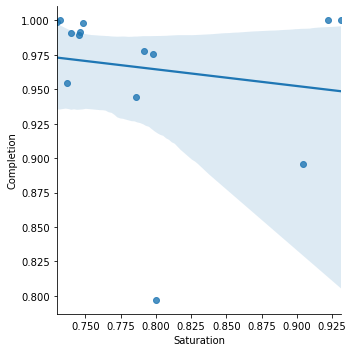

In [390]:
sns.lmplot(x='Saturation', y='Completion', data=poss_pax_routes)
plt.show()

## Conclusion
EWR SFO it is! The route is high in both saturation and completion. If we could get additional slots at these airports, that would be a good route to add flights. 
  
Also noteworthy that several of the routes on this list include Seattle, maybe a good city to explore other routes.
- Very interesting that several of these routes are operated mostly by the same airline group... Alaska Airlines and Hawaiian Airlines are the same airline.
    - Is this a result of the markets they serve/network planning strategy/some other variable I am incapable of identifying at this time?